## 1.import the library

In [2]:
# use the offical tokenization code
!cp /kaggle/input/tokenization/tokenization.py /kaggle/working/tokenization.py

In [12]:
# include libraries
import numpy as np 
import pandas as pd
import tokenization
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import to_categorical,plot_model
from sklearn import preprocessing
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/emotiondata/validation/dialogues_emotion_validation.txt
/kaggle/input/emotiondata/validation/dialogues_validation.txt
/kaggle/input/emotiondata/validation/dialogues_act_validation.txt
/kaggle/input/emotiondata/test/dialogues_test.txt
/kaggle/input/emotiondata/test/dialogues_emotion_test.txt
/kaggle/input/emotiondata/test/dialogues_act_test.txt
/kaggle/input/emotiondata/train/dialogues_train.txt
/kaggle/input/emotiondata/train/dialogues_act_train.txt
/kaggle/input/emotiondata/train/dialogues_emotion_train.txt
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv
/kaggle/input/tokenization/tokenization.py


## 2.read the data and have a grasp on the dataset

In [6]:
train_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin-1')

In [7]:
# print top 5 lines of the train data
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
# print top 5 lines of the test data
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [9]:
# print the shape of the data
train_data.shape, test_data.shape

((41157, 6), (3798, 6))

## 3.EDA part

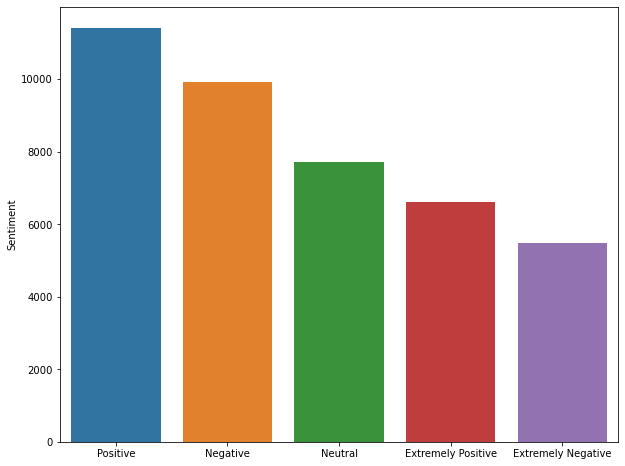

In [10]:
# plot the histgram of the training labels
plt.figure(figsize = (10,8))
data = train_data['Sentiment'].value_counts()
sns.barplot(data.index,data)

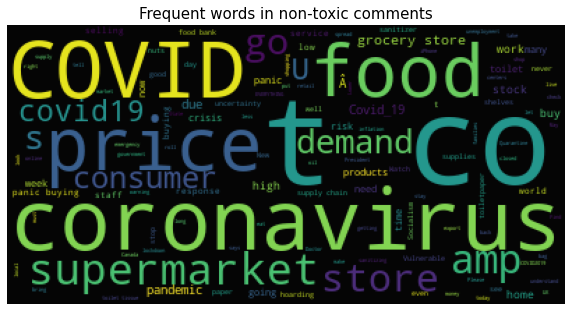

In [15]:
rnd_comments = train_data[train_data['Sentiment'] == "Negative"].sample(n=100)['OriginalTweet'].values
wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS.update(['people', 'one', 'will',"https"]))
wc.generate(" ".join(rnd_comments))

plt.figure(figsize=(10,8))
plt.axis("off")
plt.title("Frequent words in non-toxic comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [16]:
# covert TweetAt to timestamp features
train_data["timestamp"] = pd.to_datetime(train_data["TweetAt"],format="%d-%m-%Y")

In [17]:
# time based feature
train_data["weekday"] = train_data["timestamp"].dt.weekday
train_data["year"] = train_data["timestamp"].dt.year
train_data["month"] = train_data["timestamp"].dt.month
train_data["dayofmonth"] = train_data["timestamp"].dt.day

Text(0, 0.5, 'Tweet amount')

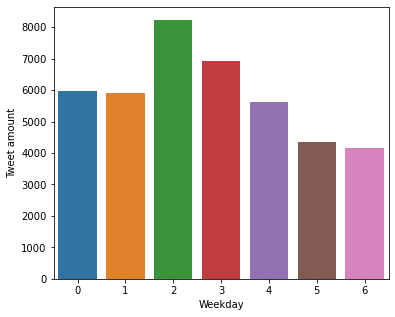

In [22]:
plt.figure(figsize = (6,5))
data = train_data['weekday'].value_counts()
sns.barplot(data.index,data)
plt.xlabel("Weekday")
plt.ylabel("Tweet amount")

Text(0, 0.5, 'Tweet amount')

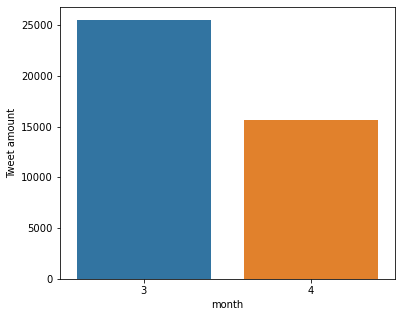

In [23]:
plt.figure(figsize = (6,5))
data = train_data['month'].value_counts()
sns.barplot(data.index,data)
plt.xlabel("month")
plt.ylabel("Tweet amount")

Text(0, 0.5, 'Tweet amount')

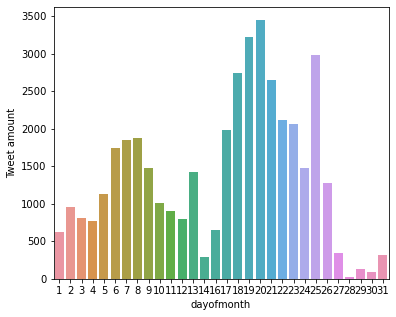

In [24]:
plt.figure(figsize = (6,5))
data = train_data['dayofmonth'].value_counts()
sns.barplot(data.index,data)
plt.xlabel("dayofmonth")
plt.ylabel("Tweet amount")

In [67]:
data = train_data.groupby(["dayofmonth","Sentiment"])["UserName"].count()
days = sorted(train_data["dayofmonth"].unique())
sentiments = sorted(train_data["Sentiment"].unique())
y = [[data[day][sentiment] for sentiment in sentiments] for day in days]

Text(0, 0.5, 'amount')

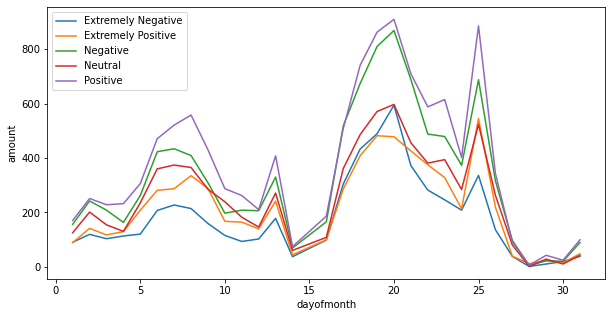

In [70]:
plt.figure(figsize = (10,5))
plt.plot(days,np.array(y))
plt.legend(sentiments)
plt.xlabel("dayofmonth")
plt.ylabel("amount")

In [25]:
# count of each location
train_data['Location'].value_counts

<bound method IndexOpsMixin.value_counts of 0                              London
1                                  UK
2                           Vagabonds
3                                 NaN
4                                 NaN
                     ...             
41152    Wellington City, New Zealand
41153                             NaN
41154                             NaN
41155                             NaN
41156    i love you so much || he/him
Name: Location, Length: 41157, dtype: object>

### 8590 null values, which need to be processed

In [71]:
# count of null value
sum(train_data['Location'].isnull())

8590

In [72]:
# one hot encoding
label = preprocessing.LabelEncoder()
y = label.fit_transform(train_data['Sentiment'])
y = to_categorical(y)
print(y[:5])

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


**Build a BERT layer**

In [73]:
# download the pretrained weight of bert model (trained on english uncased corpus)
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

**Encoding the text**

we create a BERT vocab_file in the form a numpy array. We then set the text to lowercase and finally we pass our vocab_file and do_lower_case variables to the Tokenizer object.

In [74]:
# do the tokenization part
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

# encoding function for bert model
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

**Build The Model**

In [75]:
# build model based on pretrained model
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(48, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(24, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(5, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Here We check only the first 250 characters of each text, and also we set train-test input and train labels

In [76]:
max_len = 250
train_input = bert_encode(train_data.OriginalTweet.values, tokenizer, max_len=max_len)
test_input = bert_encode(test_data.OriginalTweet.values, tokenizer, max_len=max_len)
train_labels = y

In [77]:
# print the class of labels
labels = label.classes_
print(labels)

['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']


In [78]:
# build the model and print the structure of this model
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 250)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

**Run the model**

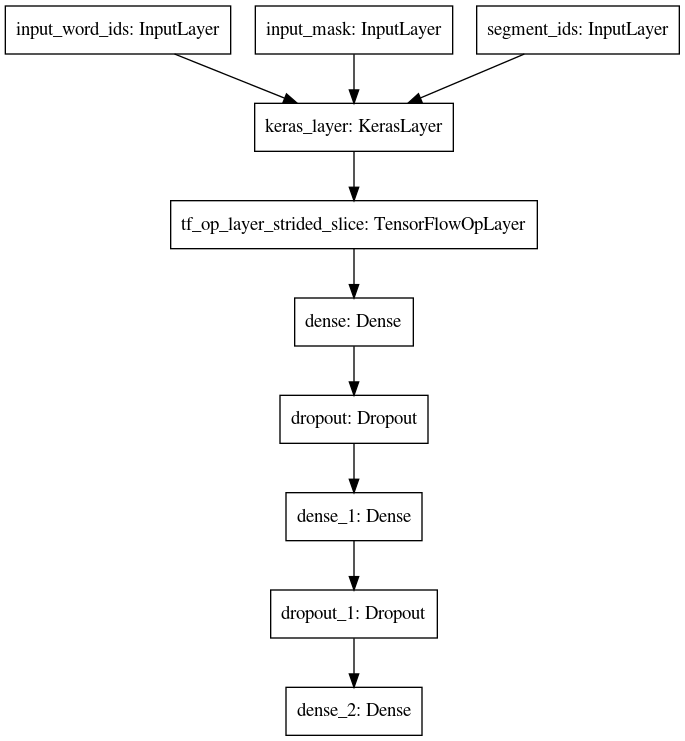

In [79]:
plot_model(model)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_sh = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/10
   8/1029 [..............................] - ETA: 14:05 - loss: 1.6365 - accuracy: 0.2148